# Bayesian signal reconstruction with Gaussian Random Fields (Wiener Filtering) - CMB example

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline
from classy import Class
import healpy as hp

## Setup Cls using CLASS

In [2]:
# Define your cosmology (what is not specified will be set to CLASS default parameters)
paramsLCDM = {
    'h':0.702,
    'n_s':0.9619,
    'Omega_b':0.045,
    'Omega_cdm':0.272-0.045,
    'output':'tCl lCl',
    'l_max_scalars': 1000,
    'ic':'ad',
}
# Create an instance of the CLASS wrapper
cosmoLCDM = Class()
# Set the parameters to the cosmological code
cosmoLCDM.set(paramsLCDM)
# Run the whole code. Depending on your output, it will call the
# CLASS modules more or less fast. For instance, without any
# output asked, CLASS will only compute background quantities,
# thus running almost instantaneously.
# This is equivalent to the beginning of the `main` routine of CLASS,
# with all the struct_init() methods called.
cosmoLCDM.compute()

In [3]:
# Compute the power spectrum for the current set of cosmological parameters
res=cosmoLCDM.raw_cl(1000)
ell=res['ell']
Cl=res['tt']

In [4]:
# Clean CLASS (the equivalent of the struct_free() in the `main`
# of CLASS. This step is primordial when running in a loop over different
# cosmologies, as you will saturate your memory very fast if you ommit
# it.
cosmoLCDM.struct_cleanup()

In [5]:
# Define a function of l from the arrays
from scipy.interpolate import InterpolatedUnivariateSpline
Clfunc = InterpolatedUnivariateSpline(ell, Cl, k=2)

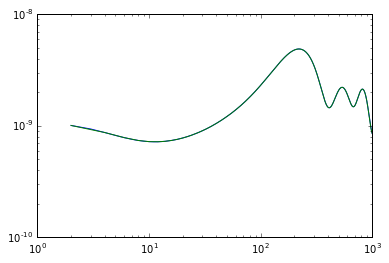

In [6]:
# Plot l*(l+1)*Cl
plt.loglog(ell,Cl*(ell*(ell+1)))
plt.loglog(np.arange(0,999,2),Clfunc(np.arange(0,999,2))*(np.arange(0,999,2)*(np.arange(0,999,2)+1)))

In [7]:
# Setup notations
nside=32
npix=hp.pixelfunc.nside2npix(nside)
lmax=min(len(Cl)-1, 3*nside-1)
nalm=hp.Alm.getsize(lmax)

## Setup signal covariance matrix

In [8]:
# Setup covariance matrix in Fourier space
covarFourier=np.zeros(nalm,dtype=complex)
for l in xrange(lmax+1):
    for m in xrange(lmax+1):
        idx=hp.Alm.getidx(lmax,l,m)
        covarFourier[idx]=Clfunc(l)

covarFouriermat=np.diagflat(covarFourier)

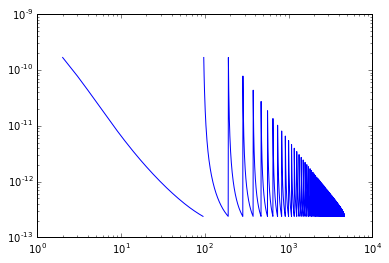

In [9]:
# Plot diagonal of the Fourier-space covariance matrix
plt.loglog(np.arange(nalm),covarFourier.real)

Above NSIDE=64 the covariance matrix can't be stored...

In [ ]:
%%capture
# Setup covariance matrix in pixel space
signalcovarPix=np.zeros((npix,npix))
for i in xrange(npix):
    ei=np.zeros(npix)
    ei[i]=1.
    alm=hp.sphtfunc.map2alm(ei)
    Calm=covarFouriermat.dot(alm)
    signalcovarPix[i]=hp.sphtfunc.alm2map(Calm,nside)

signalcovarPix=signalcovarPix.T
np.save("signalcovarPix",signalcovarPix)

In [ ]:
# Load precomputed covariance matrix in pixel space
signalcovarPix=np.load("signalcovarPix.npy")

In [ ]:
%%capture
# Compute square root of the covariance matrix
sqrtsignalcovarPix=scipy.linalg.sqrtm(signalcovarPix)
np.save("sqrtsignalcovarPix",sqrtsignalcovarPix)

In [10]:
# Load precomputed sqrt signal covariance matrix in pixel space
sqrtsignalcovarPix=np.load("sqrtsignalcovarPix.npy")

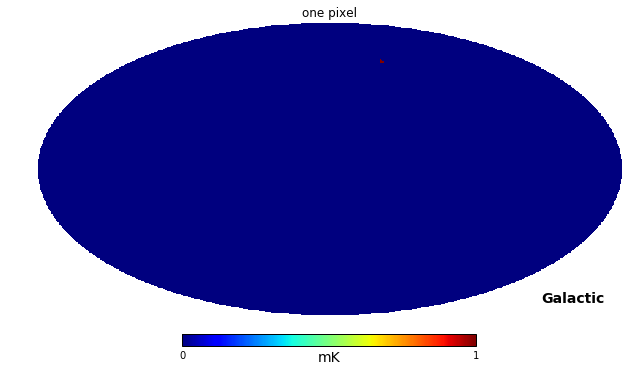

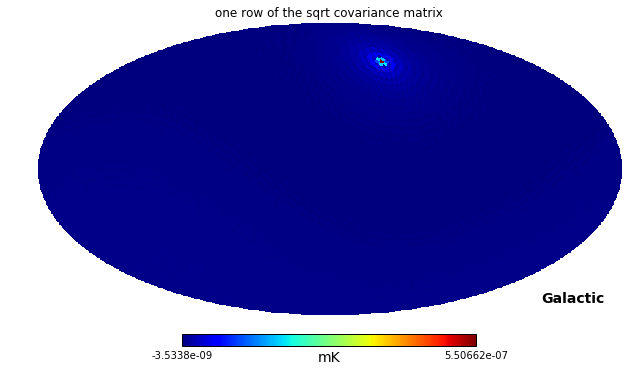

In [11]:
# Show sqrt covariance matrix in pixel space
i=1000
ei=np.zeros(npix)
ei[i]=1.
hp.mollview(ei, coord='G', title='one pixel', unit='mK')
hp.mollview(sqrtsignalcovarPix.real[i], coord='G', title='one row of the sqrt covariance matrix', unit='mK')
plt.show()

## Setup mask and noise covariance

In [12]:
# Load the mask
fn = "/home/leclercq/data/catalogs/planck_R2.01/TMASK_32_R2.01_full.fits"
tmask_map = hp.read_map(fn)
# Simplify to binary
tmask_map[np.where(tmask_map>0.)]=1.

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


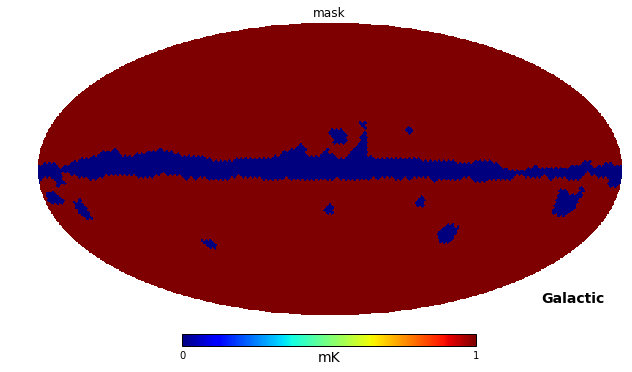

In [13]:
hp.mollview(tmask_map, coord='G', title='mask', unit='mK')
plt.show()

In [14]:
# Setup the noise covariance (infinite in masked regions)
noisepower=1e-12
noisecovar=noisepower*tmask_map
noisecovar[np.where(tmask_map==0.)]=10000.
invnoisecovar=1./noisecovar
invnoisecovarmat=np.diagflat(tmask_map/noisecovar)
np.save("invnoisecovarmat",invnoisecovarmat)

In [ ]:
# Load precomputed inverse noise covariance matrix in pixel space
invnoisecovarmat=np.load("invnoisecovarmat.npy")

## Generate mock data

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


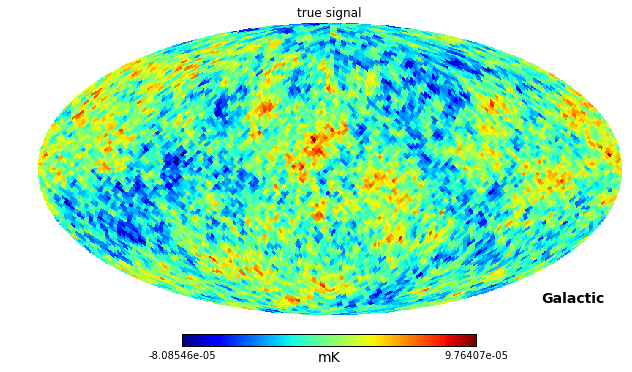

In [15]:
# Generate the true CMB signal
signal_map, signal_alms = hp.synfast(Cl, nside, alm=True, lmax=lmax, new=True)

hp.mollview(signal_map, coord='G', title='true signal', unit='mK')
plt.show()

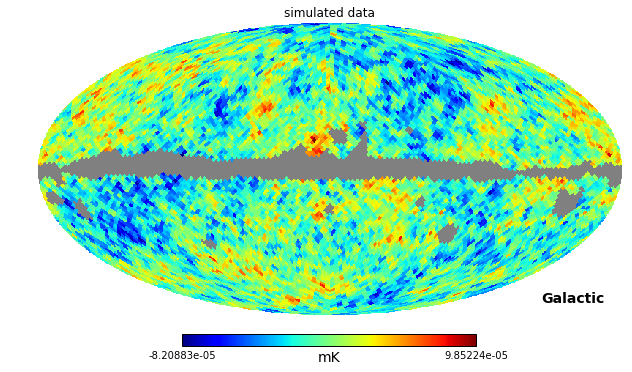

In [16]:
# Generate simulated data
epsilon=0.000000000001
normalsim = np.random.normal(0., 1., len(signal_map))
noise_map = normalsim/np.sqrt(invnoisecovar+epsilon)
data_map = signal_map + noise_map
data_map_vis = hp.ma(data_map)
data_map_vis.mask = 1-tmask_map

hp.mollview(data_map_vis, coord='G', title='simulated data', unit='mK')
plt.show()

## Setup Wiener filter

In [ ]:
# setup covariance of the Wiener filter
M=np.identity(npix)+sqrtsignalcovarPix.dot(invnoisecovarmat).dot(sqrtsignalcovarPix)
CovWF=sqrtsignalcovarPix.dot(np.linalg.inv(M)).dot(sqrtsignalcovarPix)
np.save("CovWF",CovWF)

In [ ]:
CovWF=np.load("CovWF.npy")

In [ ]:
# setup CovWF*N^-1
CovWFinvnoisecovarmat=CovWF.dot(invnoisecovarmat)
np.save("CovWFinvnoisecovarmat",CovWFinvnoisecovarmat)

In [17]:
CovWFinvnoisecovarmat=np.load("CovWFinvnoisecovarmat.npy")

In [ ]:
# setup sqrtCovWF for simulating signals
CovWFsym=(CovWF+CovWF.T)/2
sqrtCovWF=scipy.linalg.sqrtm(CovWFsym)
np.save("sqrtCovWF",sqrtCovWF)

In [18]:
sqrtCovWF=np.load("sqrtCovWF.npy")

## Perform signal reconstruction (apply Wiener Filtering)

In [19]:
# Wiener filtered map (posterior mean)
sWF=CovWFinvnoisecovarmat.dot(data_map).real

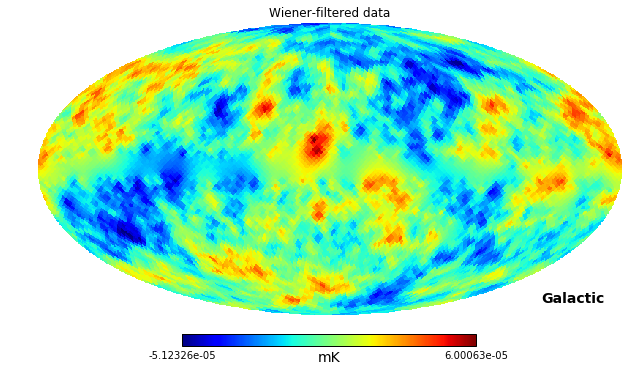

In [20]:
hp.mollview(sWF, coord='G', title='Wiener-filtered data', unit='mK')
plt.show()

## Generate constrained realizations (draw samples from the Wiener posterior)

In [21]:
cr1=sqrtCovWF.dot(np.random.normal(0.,1.,npix)).real+sWF
cr2=sqrtCovWF.dot(np.random.normal(0.,1.,npix)).real+sWF
cr3=sqrtCovWF.dot(np.random.normal(0.,1.,npix)).real+sWF

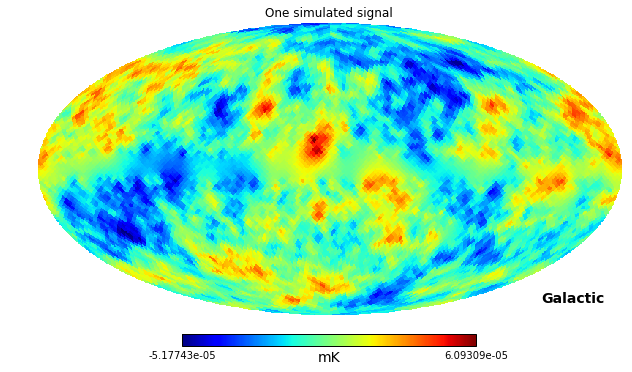

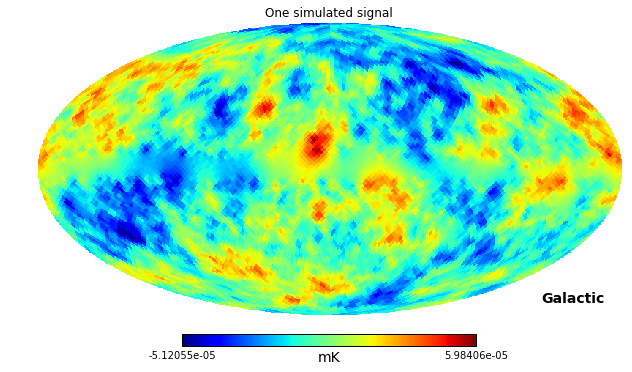

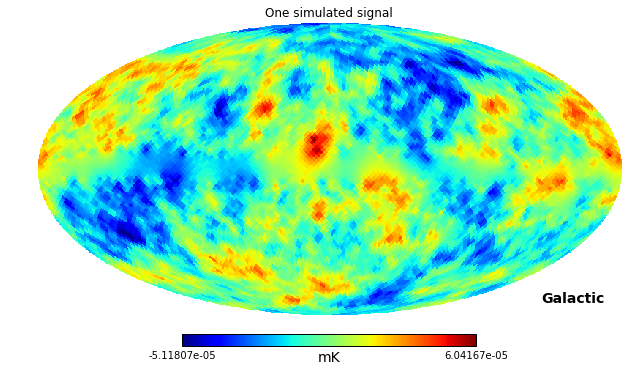

In [22]:
hp.mollview(cr1.real, coord='G', title='One simulated signal', unit='mK')
hp.mollview(cr2.real, coord='G', title='One simulated signal', unit='mK')
hp.mollview(cr3.real, coord='G', title='One simulated signal', unit='mK')
plt.show()

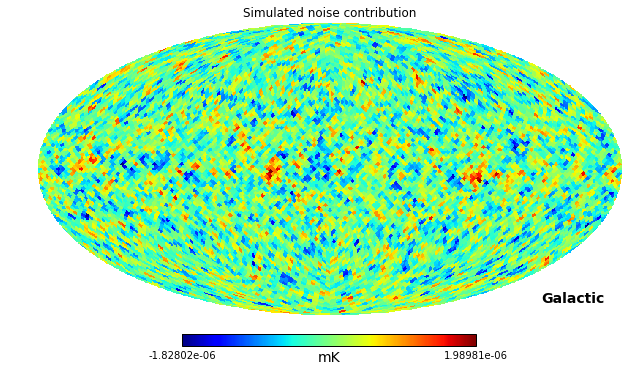

In [23]:
hp.mollview(cr1.real-sWF, coord='G', title='Simulated noise contribution', unit='mK')

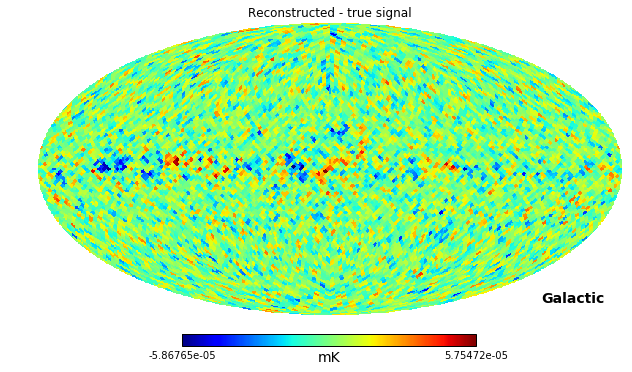

In [24]:
hp.mollview(cr1.real-signal_map, coord='G', title='Reconstructed - true signal', unit='mK')